from sklearn.preprocessing import RobustScaler
# ^^^ pyforest auto-imports - don't write above this line
___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 11<br><br>Multivariate Time Series Forecasting with RNN<br><br>(Manually)<br><h1>

# Dataset Info

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Recognizing and Understanding Data

In [4]:
df = pd.read_csv('energydata_complete.csv',index_col='date', parse_dates = True)

In [5]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890,47.597,19.200,44.790,19.790,44.730,19.000,45.567,17.167,55.200,7.027,84.257,17.200,41.627,18.200,48.900,17.033,45.530,6.600,733.500,92.000,7.000,63.000,5.300,13.275,13.275
2016-01-11 17:10:00,60,30,19.890,46.693,19.200,44.722,19.790,44.790,19.000,45.992,17.167,55.200,6.833,84.063,17.200,41.560,18.200,48.863,17.067,45.560,6.483,733.600,92.000,6.667,59.167,5.200,18.606,18.606
2016-01-11 17:20:00,50,30,19.890,46.300,19.200,44.627,19.790,44.933,18.927,45.890,17.167,55.090,6.560,83.157,17.200,41.433,18.200,48.730,17.000,45.500,6.367,733.700,92.000,6.333,55.333,5.100,28.643,28.643
2016-01-11 17:30:00,50,40,19.890,46.067,19.200,44.590,19.790,45.000,18.890,45.723,17.167,55.090,6.433,83.423,17.133,41.290,18.100,48.590,17.000,45.400,6.250,733.800,92.000,6.000,51.500,5.000,45.410,45.410
2016-01-11 17:40:00,60,40,19.890,46.333,19.200,44.530,19.790,45.000,18.890,45.530,17.200,55.090,6.367,84.893,17.200,41.230,18.100,48.590,17.000,45.400,6.133,733.900,92.000,5.667,47.667,4.900,10.084,10.084


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.000,97.695,102.525,10.000,50.000,60.000,100.000,1080.000
lights,19735.000,3.802,7.936,0.000,0.000,0.000,0.000,70.000
T1,19735.000,21.687,1.606,16.790,20.760,21.600,22.600,26.260
RH_1,19735.000,40.260,3.979,27.023,37.333,39.657,43.067,63.360
T2,19735.000,20.341,2.193,16.100,18.790,20.000,21.500,29.857
RH_2,19735.000,40.420,4.070,20.463,37.900,40.500,43.260,56.027
T3,19735.000,22.268,2.006,17.200,20.790,22.100,23.290,29.236
RH_3,19735.000,39.243,3.255,28.767,36.900,38.530,41.760,50.163
T4,19735.000,20.855,2.043,15.100,19.530,20.667,22.100,26.200
RH_4,19735.000,39.027,4.341,27.660,35.530,38.400,42.157,51.090


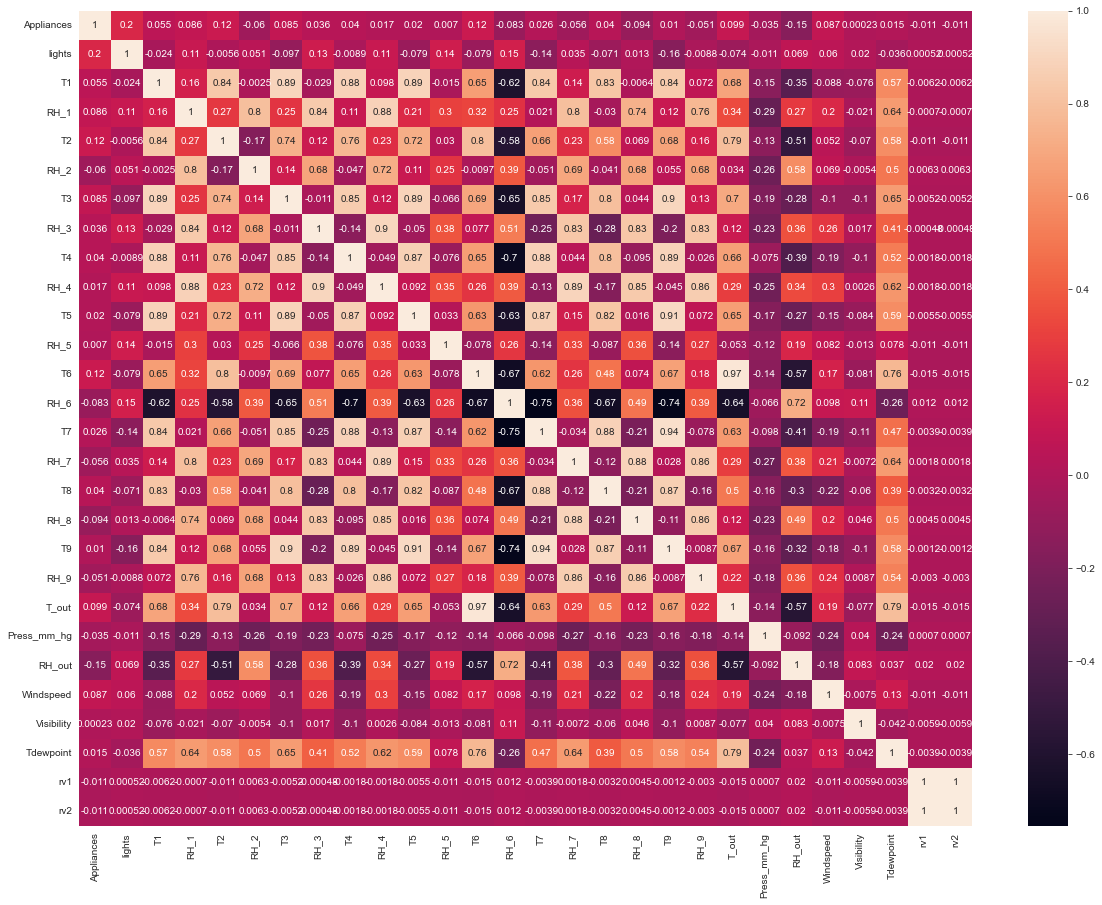

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

# Data Pre-Processing

## Feature Engineering
- Let's reduce the number of feature
- Let's resample the dataset by hours

In [9]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [10]:
df=df.rename(columns = {'T6':'T_outside', 'RH_6':'RH_outside'})
df["T_inside"] = (df["T1"] + df["T2"] + df["T3"] + df["T4"] + df["T5"] + df["T7"] + df["T8"] + df["T9"])/8
df["RH_inside"] = (df["RH_1"] + df["RH_2"] + df["RH_3"] + df["RH_4"] + df["RH_5"] + df["RH_7"] + df["RH_8"] + df["RH_9"])/8

In [11]:
drop_list = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
             'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out', 'rv1', 'rv2']
df.drop(drop_list, axis = 1, inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T_outside    19735 non-null  float64
 3   RH_outside   19735 non-null  float64
 4   Press_mm_hg  19735 non-null  float64
 5   Windspeed    19735 non-null  float64
 6   Visibility   19735 non-null  float64
 7   Tdewpoint    19735 non-null  float64
 8   T_inside     19735 non-null  float64
 9   RH_inside    19735 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.7 MB


In [13]:
df_a = df[["Appliances", "lights"]]
df_b = df.drop(["Appliances", "lights"], axis = 1)

In [14]:
df_a = df_a.resample("H").sum()
df_b = df_b.resample("H").mean()

In [15]:
df = pd.concat([df_a, df_b], axis =1)
df.head()

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,330,210,6.587,84.260,733.750,6.167,53.417,5.050,18.415,46.555
2016-01-11 18:00:00,1060,310,6.180,87.204,734.267,5.417,40.000,4.658,18.408,46.520
2016-01-11 19:00:00,1040,150,5.857,88.131,734.792,6.000,40.000,4.392,18.686,48.665
2016-01-11 20:00:00,750,210,5.469,86.934,735.283,6.000,40.000,4.017,18.941,50.356
2016-01-11 21:00:00,620,140,5.579,86.129,735.567,6.000,40.000,3.817,19.254,48.977


In [16]:
df.shape

(3290, 10)

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [17]:
df = df.round(2)

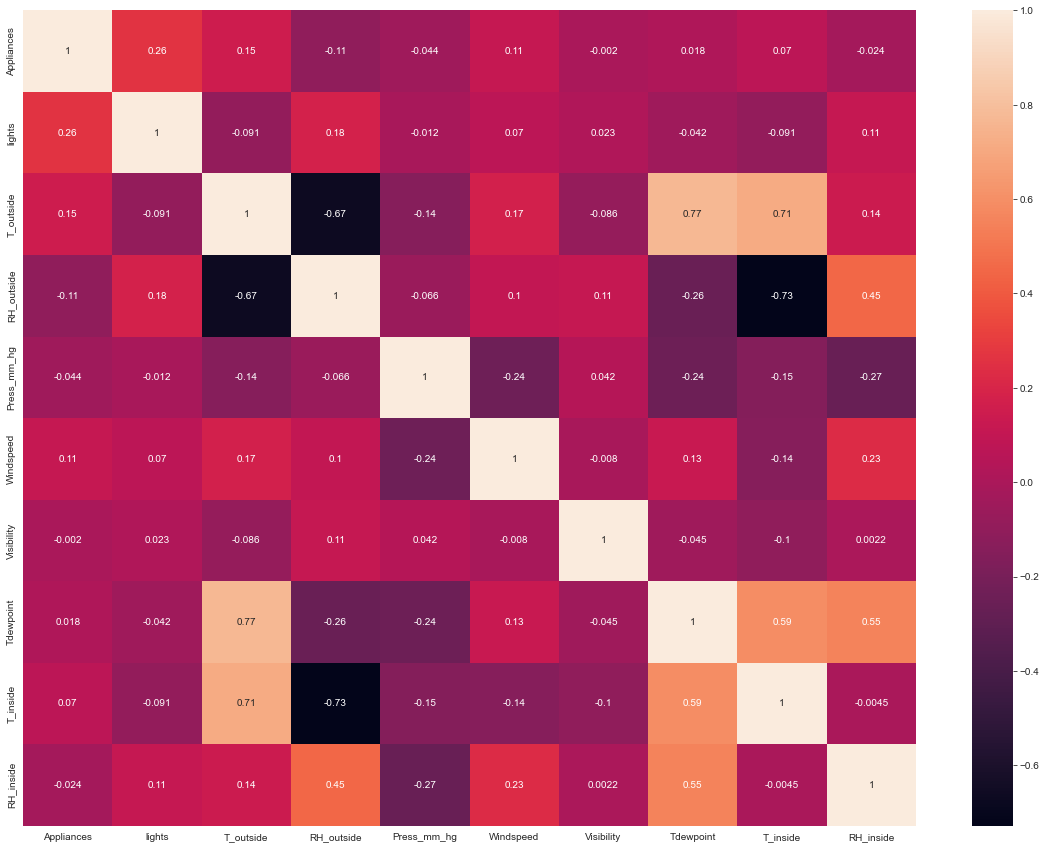

In [18]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

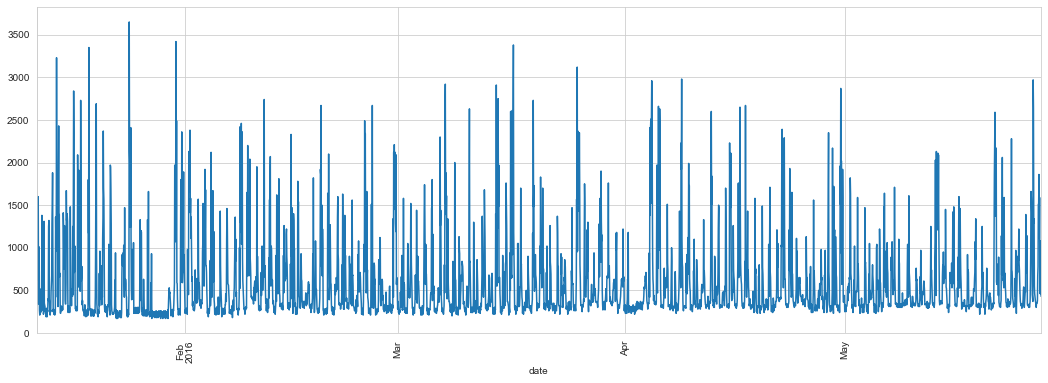

In [19]:
df['Appliances'].plot(figsize=(18,6))
plt.xticks(rotation=90);

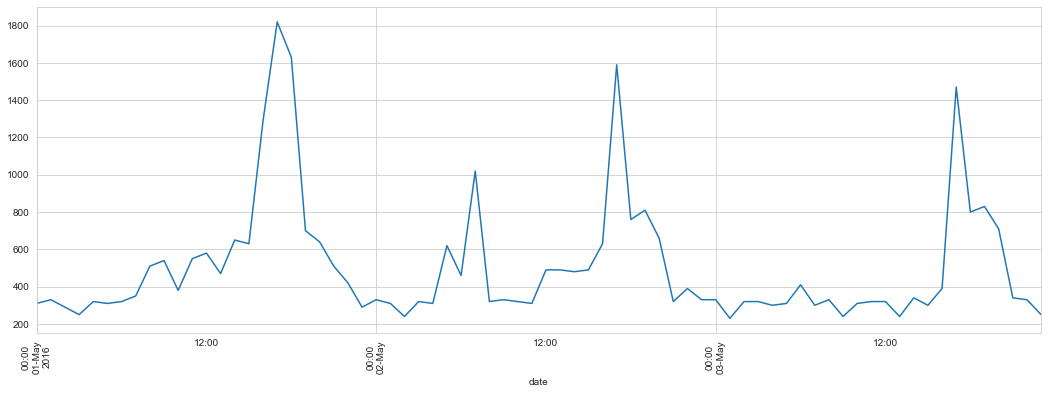

In [20]:
df['Appliances'].loc["2016-05-01 00:00:00" : "2016-05-03 23:00:00"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### Train Test Split

In [22]:
len(df)

3290

In [23]:
# How many rows per day?
24

24

In [24]:
test_days = 7

In [25]:
test_ind = test_days*24

In [26]:
test_ind

168

In [27]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [28]:
train.shape, test.shape

((3122, 10), (168, 10))

### Scale Data

In [33]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [34]:
df.columns

Index(['Appliances', 'lights', 'T_outside', 'RH_outside', 'Press_mm_hg',
       'Windspeed', 'Visibility', 'Tdewpoint', 'T_inside', 'RH_inside'],
      dtype='object')

In [35]:
f_columns = df.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

train.loc[:, f_columns] = f_transformer.fit_transform(train[f_columns])
train['Appliances'] = target_transformer.fit_transform(train[['Appliances']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns])
test['Appliances'] = target_transformer.transform(test[['Appliances']])

### Define a Function for Creating Time Steps 

In [36]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: target value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [37]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Appliances, time_steps)
X_test, y_test = create_dataset(test, test.Appliances, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3098, 24, 10) (3098,)
(144, 24, 10) (144,)


In [38]:
y_test

array([ 0.77777778,  0.55555556,  1.22222222,  0.19444444,  1.44444444,
       -0.02777778, -0.08333333, -0.16666667, -0.13888889, -0.11111111,
       -0.19444444, -0.05555556,  0.02777778,  2.13888889,  0.86111111,
        2.33333333,  4.69444444,  1.08333333,  0.69444444,  0.75      ,
        0.58333333,  0.44444444,  3.38888889,  0.97222222,  0.58333333,
        0.91666667,  0.44444444,  0.27777778, -0.02777778, -0.05555556,
       -0.16666667, -0.05555556, -0.16666667, -0.19444444,  0.08333333,
       -0.02777778, -0.08333333, -0.16666667, -0.11111111, -0.16666667,
       -0.08333333,  0.        , -0.08333333, -0.05555556,  0.19444444,
        1.58333333,  5.30555556,  1.02777778,  0.97222222,  0.72222222,
        0.11111111,  0.02777778, -0.05555556, -0.19444444, -0.08333333,
       -0.11111111, -0.13888889, -0.13888889,  0.75      ,  0.16666667,
        1.66666667, -0.08333333, -0.38888889,  0.08333333,  0.66666667,
        1.11111111,  0.94444444,  1.47222222,  1.33333333,  1.33

In [41]:
#X_test

## Model Building with LSTM

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [120]:
n_features = X_train.shape[2]

In [121]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))

#model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [122]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [123]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=24, 
          validation_split=0.3,
#          shuffle=False,
          callbacks=[early_stop])

Epoch 1/30
91/91 [==============================] - 7s 38ms/step - loss: 1.4443 - val_loss: 0.8891
Epoch 2/30
91/91 [==============================] - 1s 14ms/step - loss: 1.2156 - val_loss: 0.8625
Epoch 3/30
91/91 [==============================] - 2s 19ms/step - loss: 1.1526 - val_loss: 0.9165
Epoch 4/30
91/91 [==============================] - 3s 31ms/step - loss: 1.1310 - val_loss: 0.8355
Epoch 5/30
91/91 [==============================] - 1s 11ms/step - loss: 1.0779 - val_loss: 0.8496
Epoch 6/30
91/91 [==============================] - 3s 31ms/step - loss: 1.0544 - val_loss: 0.8869
Epoch 7/30
91/91 [==============================] - 1s 12ms/step - loss: 1.0250 - val_loss: 0.9765
Epoch 8/30
91/91 [==============================] - 3s 31ms/step - loss: 0.9872 - val_loss: 0.8872
Epoch 9/30
91/91 [==============================] - 1s 11ms/step - loss: 0.9742 - val_loss: 0.8871


<AxesSubplot:>

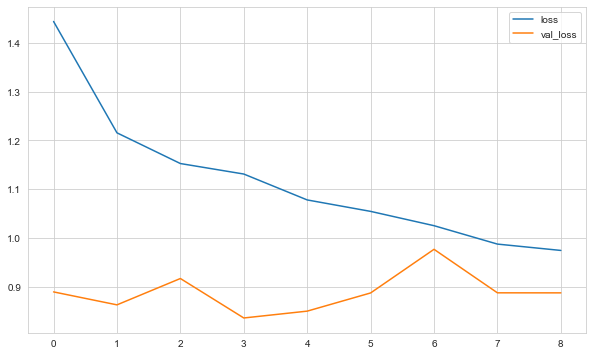

In [125]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [127]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

### First way : after each prediction, reel value will be used for next prediction¶

In [128]:
y_pred = model.predict(X_test)

In [129]:
eval_metrics(y_test, y_pred)

r2_score: 0.22616067116232086 
mae: 0.7356478292322546 
mse: 1.350260170051126 
rmse: 1.1620069578324934


### Inverse Transformation and Compare

In [130]:
y_train_inv = target_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_transformer.inverse_transform(y_pred)

In [116]:
test_index = test.iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index
pred_test

,test,prediction
date,,
2016-05-21 19:00:00,0.778,1.054
2016-05-21 20:00:00,0.556,0.748
2016-05-21 21:00:00,1.222,0.477
2016-05-21 22:00:00,0.194,0.381
2016-05-21 23:00:00,1.444,0.112
...,...,...
2016-05-27 14:00:00,0.667,1.669
2016-05-27 15:00:00,0.250,1.392
2016-05-27 16:00:00,1.222,1.072


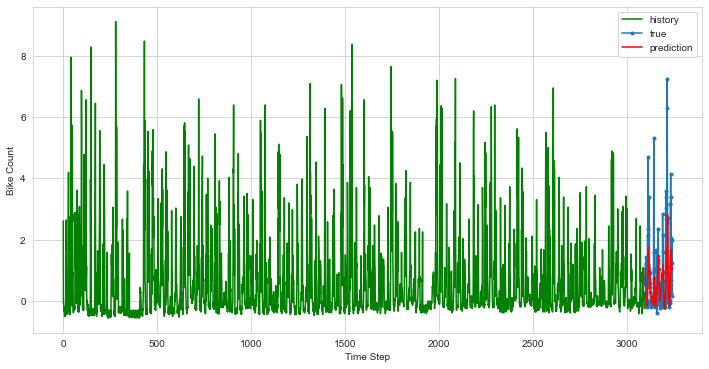

In [117]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

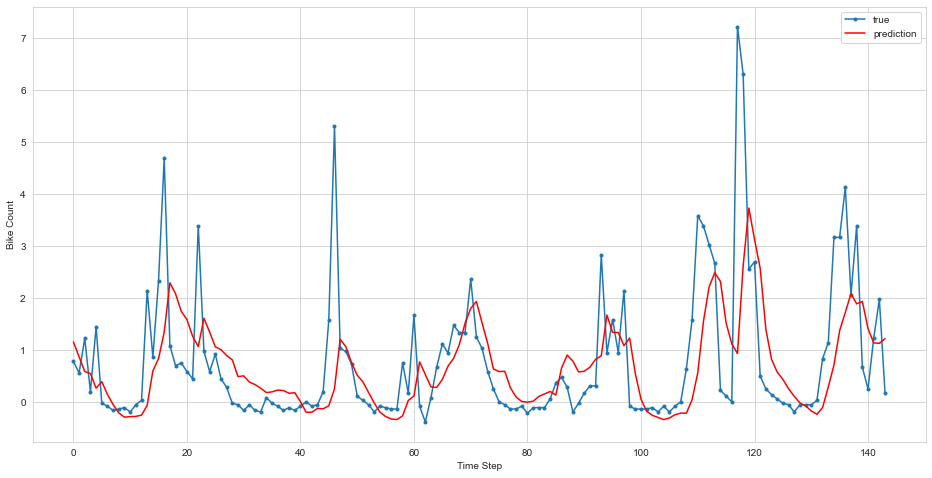

In [131]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Second way : after each prediction, result will be used for next prediction

In [138]:
test

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-05-20 19:00:00,0.056,0.000,1.852,-1.082,0.196,0.279,0.000,1.178,1.500,0.975
2016-05-20 20:00:00,0.139,0.000,1.296,-0.898,0.201,-0.115,0.000,1.151,1.423,0.790
2016-05-20 21:00:00,0.056,0.500,0.999,-0.598,0.209,-0.559,0.000,1.384,1.367,0.767
2016-05-20 22:00:00,-0.139,0.500,0.873,-0.435,0.220,-0.721,0.000,1.482,1.347,0.828
2016-05-20 23:00:00,-0.278,0.000,0.890,-0.289,0.208,-0.603,-0.561,1.631,1.321,0.889
...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,0.667,0.500,2.622,-1.090,-0.018,-0.441,-2.255,1.991,2.219,0.980
2016-05-27 15:00:00,0.250,0.000,2.722,-1.090,-0.030,-0.441,-2.224,1.949,2.214,0.896
2016-05-27 16:00:00,1.222,0.000,2.702,-1.090,-0.058,-0.324,-2.132,1.953,2.240,0.998


In [139]:
df_fake = test.iloc[:time_steps,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-20 19:00:00,0.000,1.852,-1.082,0.196,0.279,0.000,1.178,1.500,0.975
2016-05-20 20:00:00,0.000,1.296,-0.898,0.201,-0.115,0.000,1.151,1.423,0.790
2016-05-20 21:00:00,0.500,0.999,-0.598,0.209,-0.559,0.000,1.384,1.367,0.767
2016-05-20 22:00:00,0.500,0.873,-0.435,0.220,-0.721,0.000,1.482,1.347,0.828
2016-05-20 23:00:00,0.000,0.890,-0.289,0.208,-0.603,-0.561,1.631,1.321,0.889
2016-05-21 00:00:00,0.000,0.864,-0.193,0.180,-0.324,-1.398,1.829,1.301,0.941
2016-05-21 01:00:00,0.000,0.892,-0.131,0.143,-0.045,-0.857,1.833,1.286,0.964
2016-05-21 02:00:00,0.000,0.852,-0.123,0.104,0.117,0.000,1.822,1.276,0.977
2016-05-21 03:00:00,0.000,0.773,-0.107,0.076,0.117,-0.561,1.799,1.265,0.987


In [140]:
reel = np.array(test.iloc[:time_steps,:1])
reel.reshape((1,-1))[0]

array([ 0.05555556,  0.13888889,  0.05555556, -0.13888889, -0.27777778,
       -0.22222222, -0.16666667, -0.08333333, -0.22222222, -0.08333333,
       -0.16666667, -0.02777778, -0.08333333,  2.44444444,  4.13888889,
        5.36111111,  6.16666667,  2.77777778,  4.69444444,  4.02777778,
        5.        ,  0.63888889,  0.55555556,  1.05555556])

In [141]:
df_fake.shape

(24, 9)

In [142]:
df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1])).shape

(24, 1, 9)

In [145]:
predictions_scaled = []

first_eval_batch = train.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, n_features))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(time_steps):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0])
    new = features[i][0].tolist()
    new.insert(0,current_pred[0][0])
    new = np.array(new).reshape(1,1,n_features)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis=1)

In [146]:
predictions_scaled

[array([0.39624462], dtype=float32),
 array([0.2303384], dtype=float32),
 array([0.03444824], dtype=float32),
 array([-0.08015091], dtype=float32),
 array([-0.18047947], dtype=float32),
 array([-0.3652327], dtype=float32),
 array([-0.5602754], dtype=float32),
 array([-0.62633735], dtype=float32),
 array([-0.5600402], dtype=float32),
 array([-0.5405096], dtype=float32),
 array([-0.5039859], dtype=float32),
 array([-0.42845812], dtype=float32),
 array([-0.32747564], dtype=float32),
 array([-0.23390737], dtype=float32),
 array([-0.20118037], dtype=float32),
 array([-0.09958351], dtype=float32),
 array([0.01878514], dtype=float32),
 array([0.29304567], dtype=float32),
 array([0.5073032], dtype=float32),
 array([0.7006651], dtype=float32),
 array([0.88829833], dtype=float32),
 array([1.0456429], dtype=float32),
 array([1.1528219], dtype=float32),
 array([1.1780398], dtype=float32)]

In [147]:
reel

array([[ 0.05555556],
       [ 0.13888889],
       [ 0.05555556],
       [-0.13888889],
       [-0.27777778],
       [-0.22222222],
       [-0.16666667],
       [-0.08333333],
       [-0.22222222],
       [-0.08333333],
       [-0.16666667],
       [-0.02777778],
       [-0.08333333],
       [ 2.44444444],
       [ 4.13888889],
       [ 5.36111111],
       [ 6.16666667],
       [ 2.77777778],
       [ 4.69444444],
       [ 4.02777778],
       [ 5.        ],
       [ 0.63888889],
       [ 0.55555556],
       [ 1.05555556]])

In [148]:
eval_metrics(reel, predictions_scaled)

r2_score: -0.33664680497606825 
mae: 1.5554262882150296 
mse: 6.129562049284645 
rmse: 2.475795235734297


### Inverse Transformation and Compare

In [149]:
predictions = target_transformer.inverse_transform(predictions_scaled)
reel = target_transformer.inverse_transform(reel)

In [150]:
compare = pd.DataFrame(data = reel, index = test.index[:time_steps], columns = ["reel"])
compare["prediction"] = predictions
compare

,reel,prediction
date,,
2016-05-20 19:00:00,0.056,0.396
2016-05-20 20:00:00,0.139,0.230
2016-05-20 21:00:00,0.056,0.034
2016-05-20 22:00:00,-0.139,-0.080
2016-05-20 23:00:00,-0.278,-0.180
2016-05-21 00:00:00,-0.222,-0.365
2016-05-21 01:00:00,-0.167,-0.560
2016-05-21 02:00:00,-0.083,-0.626
2016-05-21 03:00:00,-0.222,-0.560


<AxesSubplot:xlabel='date'>

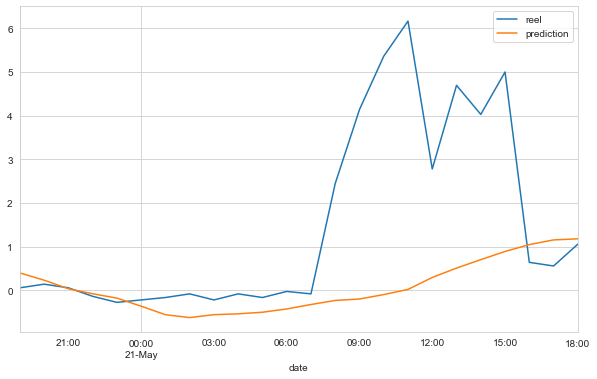

In [151]:
compare.plot()

## Retrain and Forecasting with Full Data

### Scale full data

In [152]:
df_scaled = df.copy()

In [153]:
f_columns = df_scaled.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

df_scaled.loc[:, f_columns] = f_transformer.fit_transform(df_scaled[f_columns])
df_scaled['Appliances'] = target_transformer.fit_transform(df_scaled[['Appliances']])

In [154]:
df_scaled

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,-0.139,10.500,-0.092,0.546,-2.233,0.757,1.643,0.290,-1.038,1.027
2016-01-11 18:00:00,1.889,15.500,-0.146,0.601,-2.181,0.538,0.000,0.221,-1.043,1.022
2016-01-11 19:00:00,1.833,7.500,-0.188,0.619,-2.129,0.708,0.000,0.173,-0.910,1.392
2016-01-11 20:00:00,1.028,10.500,-0.239,0.596,-2.080,0.708,0.000,0.107,-0.790,1.682
2016-01-11 21:00:00,0.667,7.000,-0.225,0.581,-2.051,0.708,0.000,0.072,-0.643,1.445
...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,0.639,0.500,2.403,-1.016,-0.030,-0.462,-2.255,1.785,2.024,0.914
2016-05-27 15:00:00,0.222,0.000,2.496,-1.016,-0.043,-0.462,-2.224,1.746,2.019,0.833
2016-05-27 16:00:00,1.194,0.000,2.478,-1.016,-0.072,-0.339,-2.132,1.749,2.043,0.931


Let's devide dataset as "full" and "val". We can think about this "val" data as the weather forecast of next days.

In [176]:
val_size = 24
val = df_scaled.iloc[-val_size:]
full = df_scaled.iloc[:-val_size]
print(len(full), len(val))

3266 24


### reshape to [samples, time_steps, n_features]

In [177]:
X, y = create_dataset(full, full.Appliances, time_steps)

print(X.shape, y.shape)

(3242, 24, 10) (3242,)


### Create Final model with full data

In [178]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))

#model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [179]:
model.fit(X, y, 
          epochs=15, 
          batch_size=24, 
         # shuffle=False
         )

Epoch 1/15
136/136 [==============================] - 6s 23ms/step - loss: 1.2840
Epoch 2/15
136/136 [==============================] - 1s 10ms/step - loss: 1.0942
Epoch 3/15
136/136 [==============================] - 3s 22ms/step - loss: 1.0597
Epoch 4/15
136/136 [==============================] - 2s 14ms/step - loss: 1.0213
Epoch 5/15
136/136 [==============================] - 2s 18ms/step - loss: 1.0062
Epoch 6/15
136/136 [==============================] - 3s 23ms/step - loss: 0.9563
Epoch 7/15
136/136 [==============================] - 1s 10ms/step - loss: 0.9409
Epoch 8/15
136/136 [==============================] - 2s 17ms/step - loss: 0.9087
Epoch 9/15
136/136 [==============================] - 3s 21ms/step - loss: 0.8776
Epoch 10/15
136/136 [==============================] - 3s 23ms/step - loss: 0.8553
Epoch 11/15
136/136 [==============================] - 1s 11ms/step - loss: 0.8047
Epoch 12/15
136/136 [==============================] - 3s 23ms/step - loss: 0.7835
Epoch 13/15
1

<AxesSubplot:>

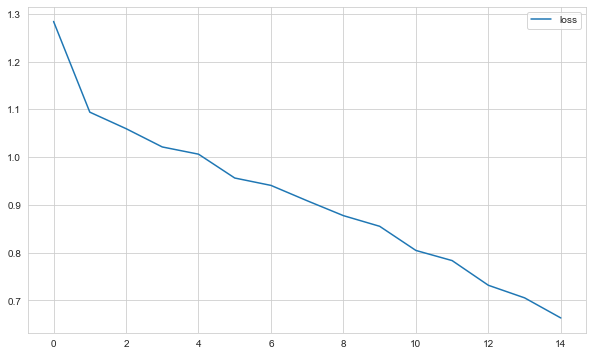

In [180]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### forecasting

In [181]:
df_fake = val.iloc[:,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-26 19:00:00,0.000,2.011,-1.016,-0.060,-0.170,-0.786,1.134,1.862,0.749
2016-05-26 20:00:00,4.500,1.634,-1.006,-0.048,-0.170,-0.867,1.237,1.838,1.143
2016-05-26 21:00:00,4.000,1.311,-0.842,-0.018,-0.047,-0.092,1.368,1.762,0.990
2016-05-26 22:00:00,6.000,1.111,-0.704,0.000,0.123,2.794,1.444,1.738,0.974
2016-05-26 23:00:00,5.500,0.996,-0.619,0.000,0.000,2.886,1.403,1.695,0.954
2016-05-27 00:00:00,1.000,0.932,-0.513,-0.008,-0.292,2.764,1.355,1.671,0.966
2016-05-27 01:00:00,0.000,0.910,-0.465,-0.028,-0.462,2.693,1.338,1.633,0.959
2016-05-27 02:00:00,0.000,0.875,-0.401,-0.036,-0.585,2.641,1.334,1.605,0.974
2016-05-27 03:00:00,0.000,0.833,-0.336,-0.043,-0.389,2.163,1.375,1.576,0.983


In [182]:
reel = np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([ 2.66666667,  0.47222222,  0.22222222,  0.11111111,  0.02777778,
       -0.05555556, -0.08333333, -0.22222222, -0.08333333, -0.08333333,
       -0.08333333,  0.        ,  0.80555556,  1.11111111,  3.13888889,
        3.13888889,  4.11111111,  2.02777778,  3.36111111,  0.63888889,
        0.22222222,  1.19444444,  1.94444444,  0.13888889])

### First way : after each prediction, reel value will be use for next prediction¶

In [183]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,reel[i][0])
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [184]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: 0.0006796669480035877 
mae: 0.9936233975545123 
mse: 1.7319057137381713 
rmse: 1.3160188880628467


In [185]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[ 959.2909 ,  769.70416,  419.70895,  558.5651 ,  575.9766 ,
         526.3487 ,  446.87662,  341.0108 ,  231.92581,  203.58371,
         171.87283,  194.89357,  299.43958,  549.18353,  718.95087,
         908.3355 ,  837.11633,  794.60095,  551.54724,  492.88544,
         499.9485 , 1474.0256 , 1726.0175 , 1279.7678 ]], dtype=float32)

In [186]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [187]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

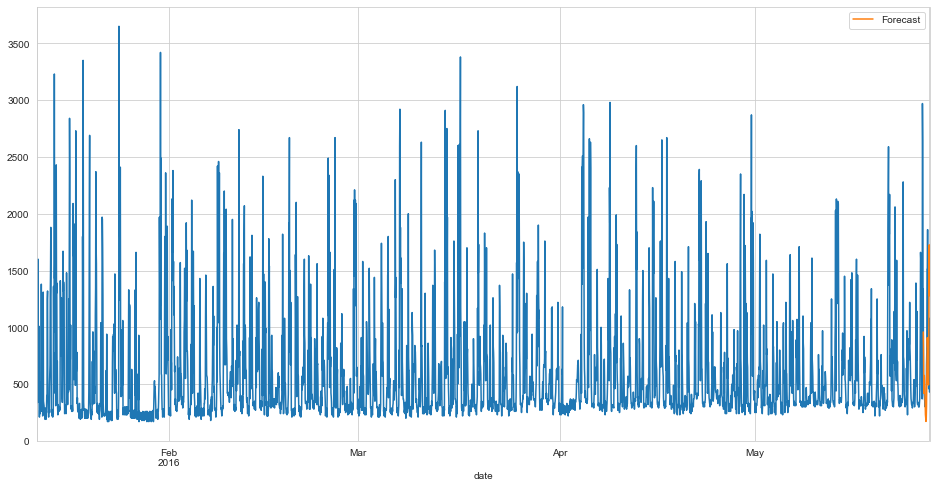

In [188]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

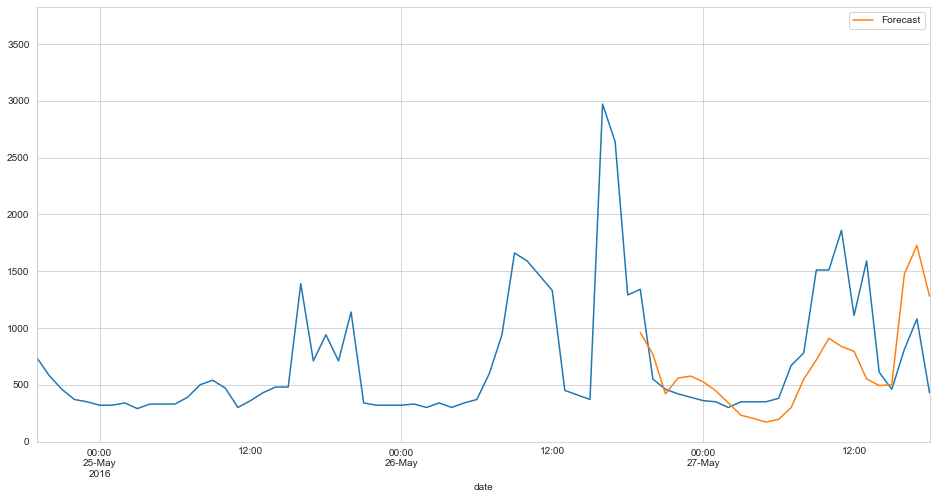

In [189]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

### Second way : after each prediction, result will be use for next prediction

In [190]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,current_pred)
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [191]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: -0.8378950984297127 
mae: 1.306938166350678 
mse: 3.185225914998147 
rmse: 1.7847201223155822


In [192]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[ 959.2909  ,  645.8092  ,  466.30984 ,  596.75183 ,  635.44336 ,
         606.39026 ,  528.51215 ,  420.24924 ,  303.5159  ,  220.7854  ,
         148.7087  ,  134.62952 ,  204.51727 ,  347.64487 ,  473.4781  ,
         489.93768 ,  366.82944 ,  229.49303 ,   93.24344 ,    8.468384,
          83.23712 ,  839.61975 , 1452.8721  , 1443.7678  ]],
      dtype=float32)

In [193]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [194]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

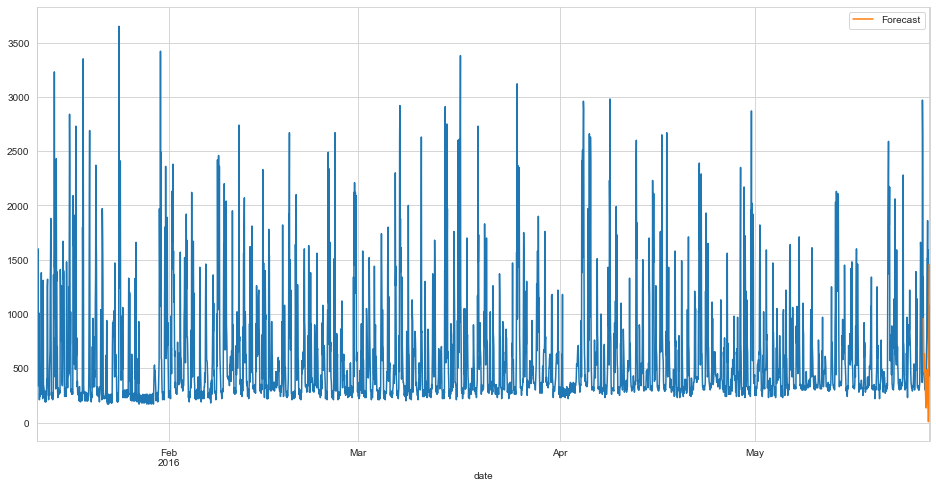

In [195]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

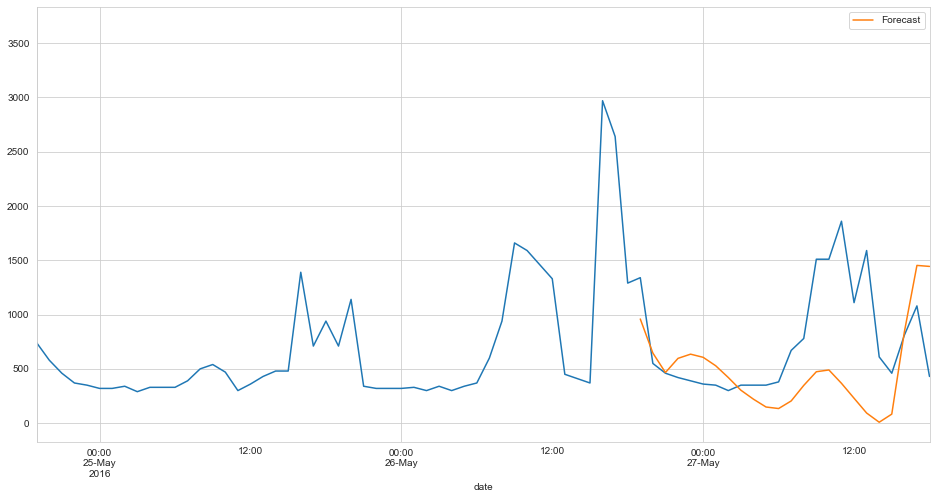

In [196]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

<p style="text-align: center"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>